In [1]:
import random
import time
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from copy import deepcopy
from typing import Dict, List, Tuple

In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as ticker

In [3]:
# Load DCIts
import sys
import os
sys.path.append('..')
from src.dcits import DCITS

In [4]:
# Load utils
from src.utils import *

In [5]:
# Set random seeds for reproducibility
seed = 1000

In [6]:
# Check if CUDA is available
if torch.cuda.is_available():
    # Specify the device (index starts from 0, so cuda:0 is the first GPU)
    device = torch.device("cuda:0")
    print(f"Using {torch.cuda.get_device_name(device)}")
else:
    print("CUDA is not available. Using CPU instead.")
    device = torch.device("cpu")

Using NVIDIA RTX A4000


## Data generation parameters

In [7]:
mean = 0
std = 0.1
frequency = 0.3
ts_length = 20000
burn_in = 1000

# Dataset 1

The dataset is defined by the following equation:

$$
X_{n,t}=\alpha^\text{gt}_n + \epsilon_{n,t}.
$$

The ground-truth coefficients are specified as:

$$
\alpha^\text{gt}_n=N(0,1)
$$

In [8]:
dataset_name="Dataset 1"

In [9]:
# gp = generating process
no_of_timeseries_gp = 5
window_length_gp = 1

# Define deterministic ground truth alpha coefficients
ground_truth_alpha = torch.zeros(no_of_timeseries_gp, no_of_timeseries_gp, window_length_gp)
# Create a mask with the same shape as ground_truth_alpha (can be usefull in analysis)
alpha_mask = (ground_truth_alpha != 0).float()  # 1 where there's a non-zero value, 0 otherwise

# How to apply mask to the alpha tensor
# masked_alpha = ground_truth_alpha * alpha_mask

# Create bias tensor
ground_truth_bias = torch.randn(no_of_timeseries_gp)

In [10]:
ground_truth_bias

tensor([ 0.8043,  1.5674, -0.1566,  0.4006, -0.8358])

In [11]:
time_series = dataset(ts_length, ground_truth_alpha, 
                           ground_truth_bias, noise_frequency=frequency, 
                           mu=mean, sigma=std, seed=seed)
time_series.shape

torch.Size([5, 20000])

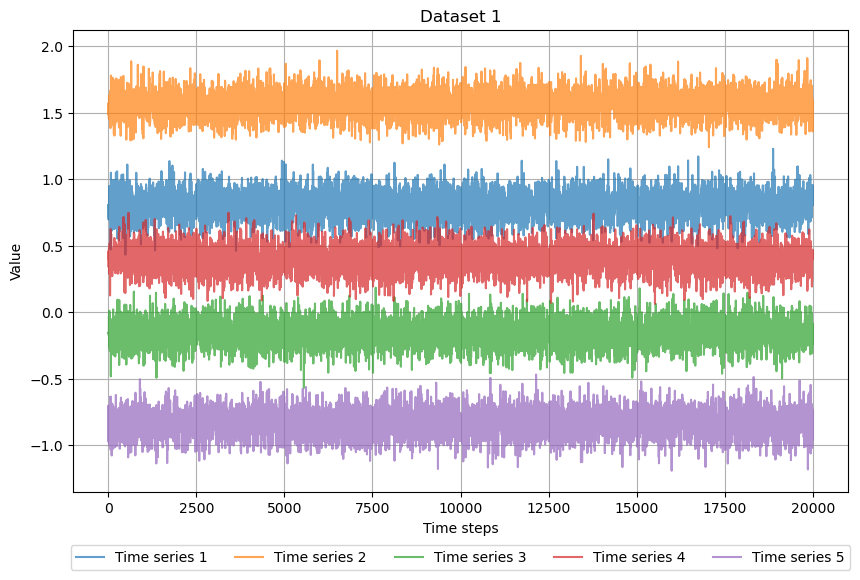

In [12]:
plot_ts(time_series, dataset_name=dataset_name,alpha=0.7)

# Train 

In [13]:
train_config = {
    'verbose': True,
    'device' : device,
    'learning_rate': 1e-3,
    'scheduler_patience': 5,
    'early_stopping_modifier': 2, # 3 will give results comparable to MAE
    #'criterion': nn.MSELoss() # MSE
    'criterion': nn.L1Loss() # MAE
}

In [14]:
test_loss, train_losses, val_losses, f_test, c_test, debug_info,_,_,_ = train_and_evaluate(
    time_series=time_series,
    window_size=1,
    temperature=1,
    order=[1,1],
    config=train_config
)

Epoch 1/100, Train Loss: 6.324430e-02, Val Loss: 3.244960e-02, LR: 1.00e-03
Epoch 2/100, Train Loss: 3.106272e-02, Val Loss: 2.938253e-02, LR: 1.00e-03
Epoch 3/100, Train Loss: 3.059279e-02, Val Loss: 3.115716e-02, LR: 1.00e-03
Epoch 4/100, Train Loss: 3.009317e-02, Val Loss: 2.640627e-02, LR: 1.00e-03
Epoch 5/100, Train Loss: 2.909104e-02, Val Loss: 2.568030e-02, LR: 1.00e-03
Epoch 6/100, Train Loss: 2.904511e-02, Val Loss: 2.993971e-02, LR: 1.00e-03
Epoch 7/100, Train Loss: 2.847326e-02, Val Loss: 2.608541e-02, LR: 1.00e-03
Epoch 8/100, Train Loss: 2.817482e-02, Val Loss: 2.669600e-02, LR: 1.00e-03
Epoch 9/100, Train Loss: 2.791899e-02, Val Loss: 2.701696e-02, LR: 1.00e-03
Epoch 10/100, Train Loss: 2.787608e-02, Val Loss: 2.751006e-02, LR: 1.00e-03
Epoch 11/100, Train Loss: 2.744563e-02, Val Loss: 2.550530e-02, LR: 1.00e-03
Epoch 12/100, Train Loss: 2.722293e-02, Val Loss: 2.646670e-02, LR: 1.00e-03
Epoch 13/100, Train Loss: 2.717120e-02, Val Loss: 2.749761e-02, LR: 1.00e-03
Epoch 14

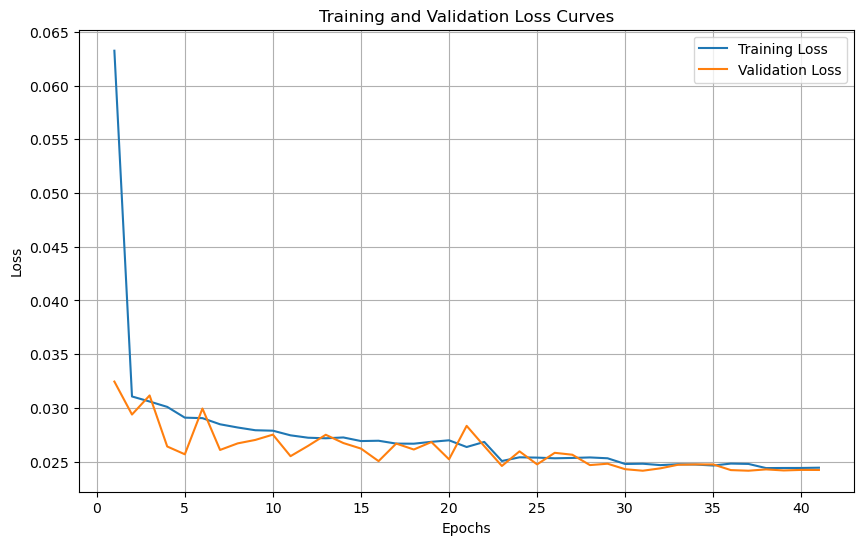

In [15]:
# Plot training and validation loss curves
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses)+1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.grid(True)

# Interpretability

In [16]:
alpha = {}
alpha_std = {}
for i in f_test.keys():
    if i==0:
        alpha_bias = (f_test[0] * c_test[0]).mean(0)  # Mean of bias alpha coefficients
        alpha_bias_std = (f_test[0] * c_test[0]).std(0)  # Std of bias alpha coefficients
    else:
        alpha[i] = (f_test[i] * c_test[i]).mean(0)  # Mean of regularn alpha coefficients
        alpha_std[i] = (f_test[i] * c_test[i]).std(0)  # Std of regularn alpha coefficients

In [17]:
# Compute beta_tilde_tmp, beta_tilde, and beta_tilde_std using NumPy
beta_tilde_tmp = np.abs(f_test[1] * c_test[1]).sum(axis=-1)  # sum along the last axis
beta_tilde = beta_tilde_tmp.mean(axis=0)  # mean along the 0th axis
beta_tilde_std = beta_tilde_tmp.std(axis=0)  # std along the 0th axis

# Compute beta and beta_std
beta = beta_tilde / beta_tilde.sum(1,keepdims=True)  # Normalize beta_tilde
beta_std = (beta_tilde_tmp / beta_tilde_tmp.sum(axis=1, keepdims=True)).std(axis=0)  # std after normalization

## $\alpha$ bias

In [18]:
print_bias(alpha_bias, alpha_bias_std, ground_truth_bias)

bias_1 = (0.585061 ± 0.000008), gt_bias_1 = 0.804282
bias_2 = (1.55078 ± 0.00002), gt_bias_2 = 1.56738
bias_3 = (-0.111967 ± 0.000003), gt_bias_3 = -0.156623
bias_4 = (0.41476 ± 0.00002), gt_bias_4 = 0.40063
bias_5 = (-0.487914 ± 0.000006), gt_bias_5 = -0.835751


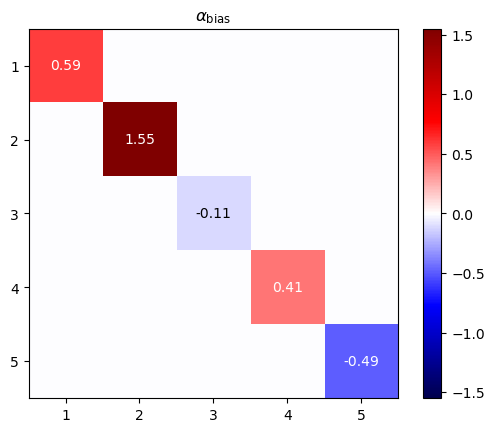

In [19]:
plot_bias(alpha_bias)

## $\alpha$ first order

In [20]:
print_significant_alpha(alpha[1], alpha_std[1],ground_truth_alpha,threshold=0.01)

alpha_111 = (0.134 ± 0.004) Not in ground truth
alpha_121 = (0.027 ± 0.003) Not in ground truth
alpha_131 = (-0.034 ± 0.002) Not in ground truth
alpha_151 = (-0.0718 ± 0.0010) Not in ground truth
alpha_251 = (-0.033 ± 0.002) Not in ground truth
alpha_311 = (-0.0316 ± 0.0007) Not in ground truth
alpha_351 = (0.0288 ± 0.0005) Not in ground truth
alpha_411 = (-0.0157 ± 0.0006) Not in ground truth
alpha_511 = (-0.192 ± 0.005) Not in ground truth
alpha_521 = (-0.089 ± 0.003) Not in ground truth
alpha_531 = (0.062 ± 0.001) Not in ground truth
alpha_551 = (0.049 ± 0.003) Not in ground truth


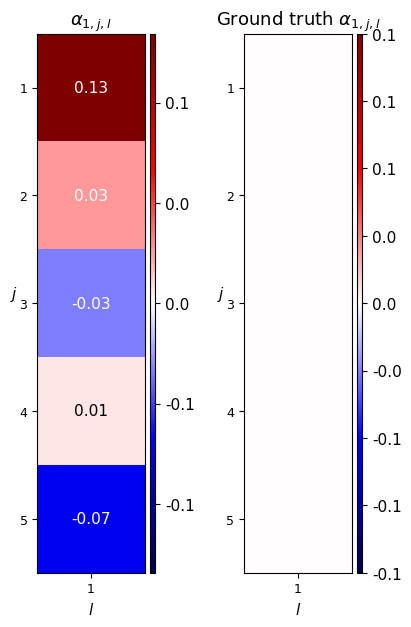

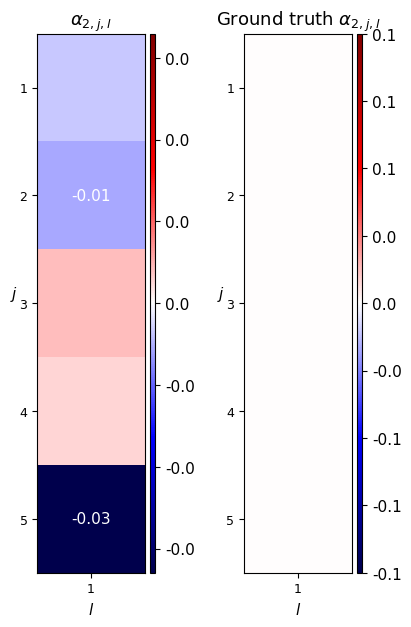

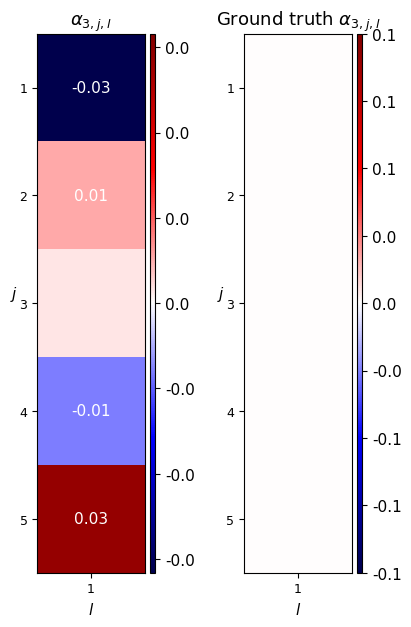

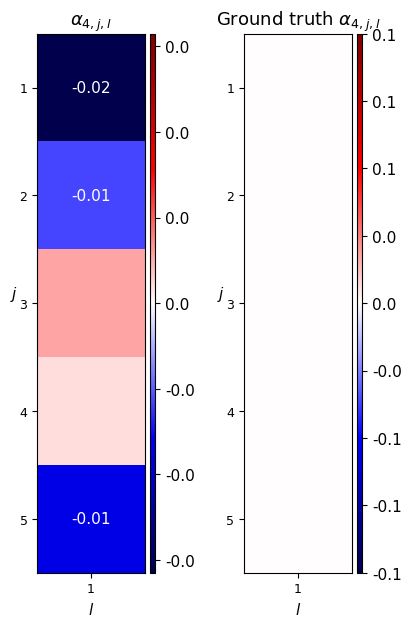

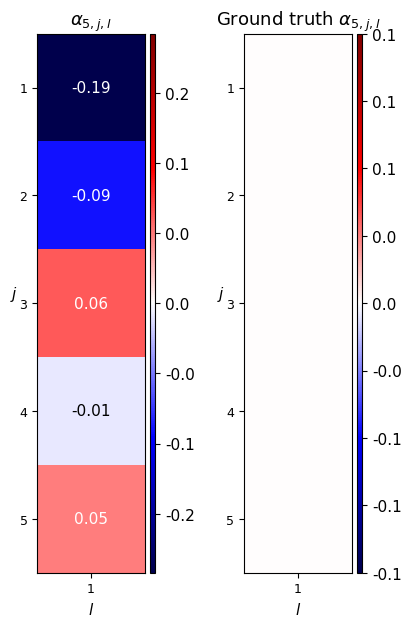

In [21]:
plot_alphas(alpha[1],ground_truth_alpha, figsize=(8, 7), font_size=11, space=-0.8)

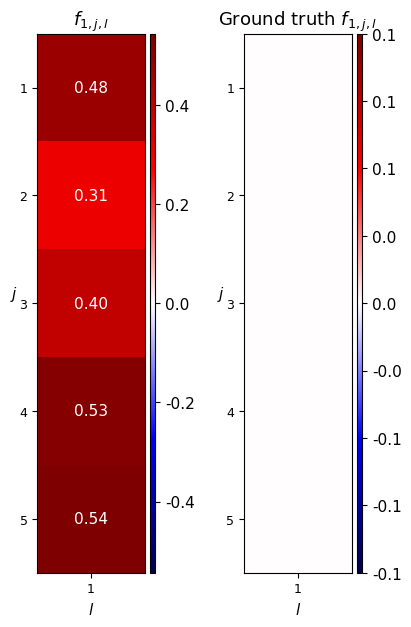

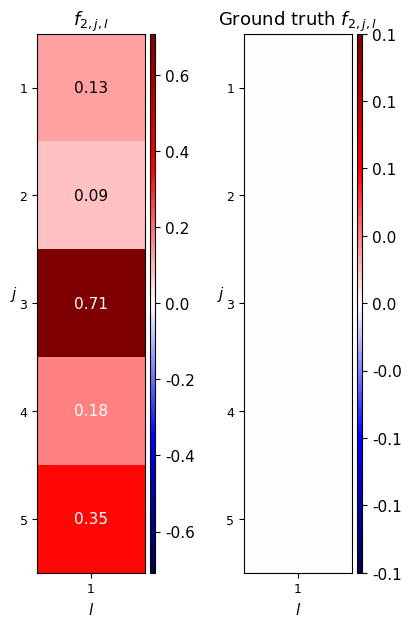

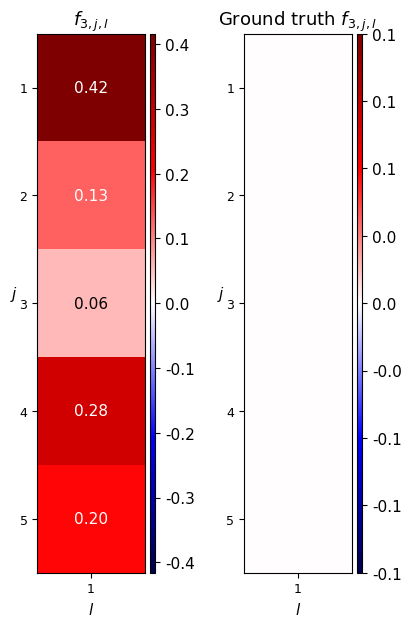

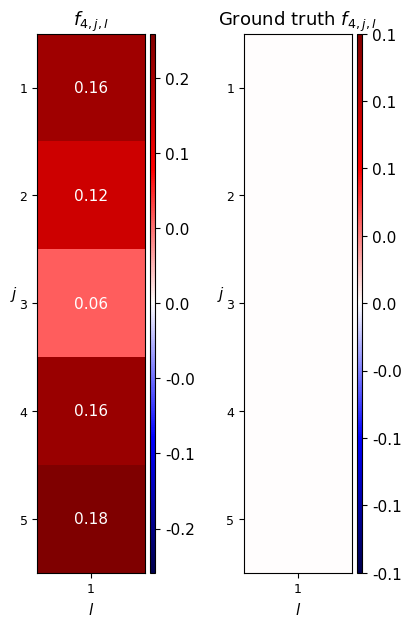

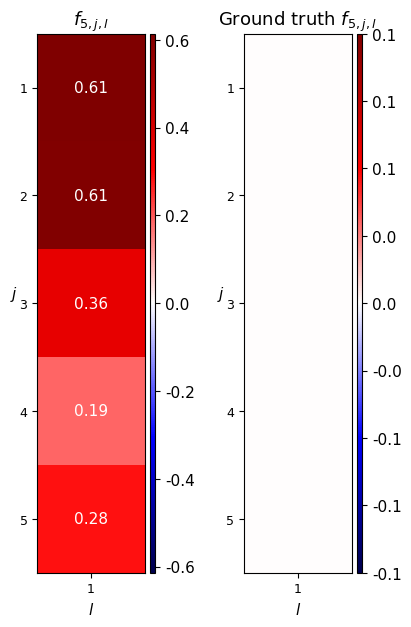

In [22]:
plot_alphas(f_test[1].mean(0),alpha_mask, title=r'f', figsize=(8, 7), font_size=11, space=-0.8)

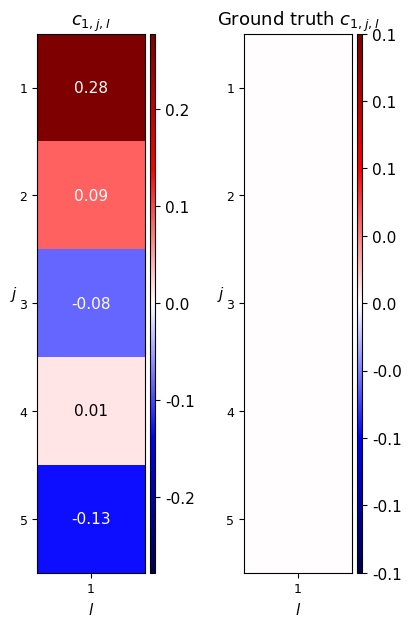

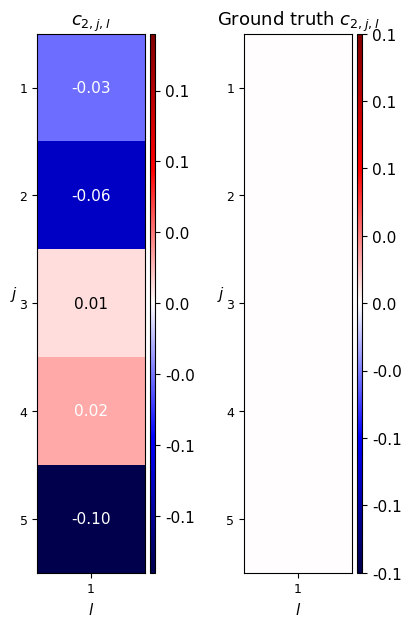

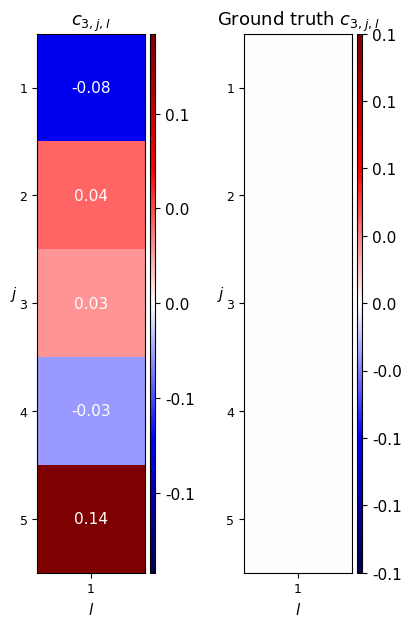

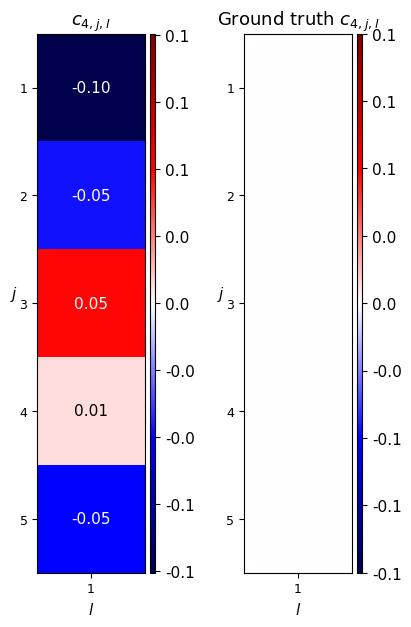

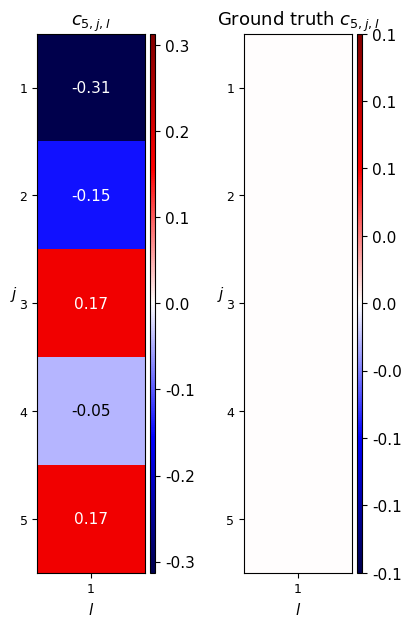

In [23]:
plot_alphas(c_test[1].mean(0),ground_truth_alpha, title=r'c', figsize=(8, 7), font_size=11, space=-0.8)

# Test stabitliy on multiple runs

In [24]:
# Do not print train/eval output
train_config['verbose'] = False

# Collect results from multiple runs
results = collect_multiple_runs(
    n_runs=5,
    time_series=time_series,
    window_size=1,
    temperature=1.0,
    order=[1,1],
    config=train_config,
    verbose=True
)

Training Configuration:
  verbose: False
  device: cuda:0
  learning_rate: 0.001
  scheduler_patience: 5
  early_stopping_modifier: 2
  criterion: L1Loss()
Starting Run 1/5
Run 1 completed. Test Loss: 2.375562e-02
Starting Run 2/5
Run 2 completed. Test Loss: 2.376328e-02
Starting Run 3/5
Run 3 completed. Test Loss: 2.376786e-02
Starting Run 4/5
Run 4 completed. Test Loss: 2.375902e-02
Starting Run 5/5
Run 5 completed. Test Loss: 2.383303e-02
Time taken for Run 2: 74.36 seconds


In [25]:
stats = calculate_multiple_run_statistics(results)

In [26]:
stats.keys()

dict_keys(['alpha', 'alpha_bias', 'beta', 'f', 'c'])

In [27]:
print_bias(stats['alpha_bias']['mean'],stats['alpha_bias']['std'], ground_truth_bias)

bias_1 = (0.72 ± 0.07), gt_bias_1 = 0.80
bias_2 = (1.3 ± 0.2), gt_bias_2 = 1.6
bias_3 = (-0.11 ± 0.03), gt_bias_3 = -0.16
bias_4 = (0.34 ± 0.06), gt_bias_4 = 0.40
bias_5 = (-0.75 ± 0.08), gt_bias_5 = -0.84


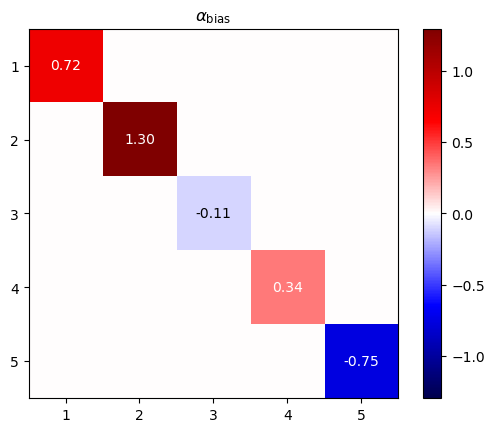

In [28]:
plot_bias(stats['alpha_bias']['mean'])

In [29]:
print_significant_alpha(stats['alpha'][1]['mean'], stats['alpha'][1]['std'],ground_truth_alpha, threshold=0.01)

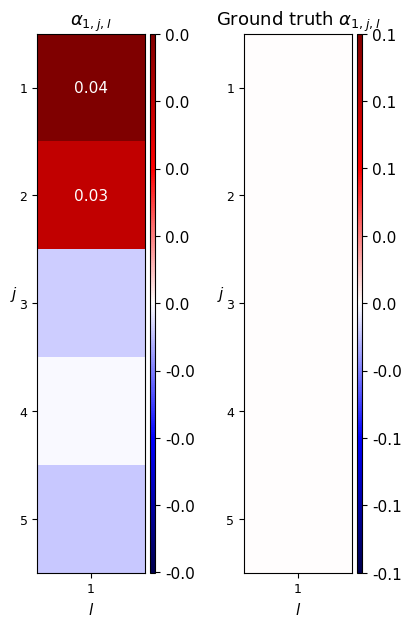

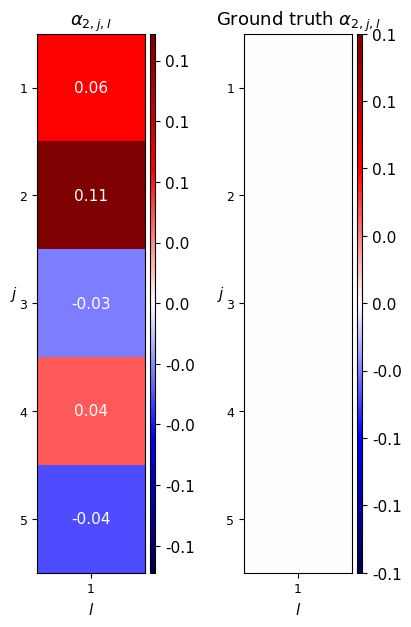

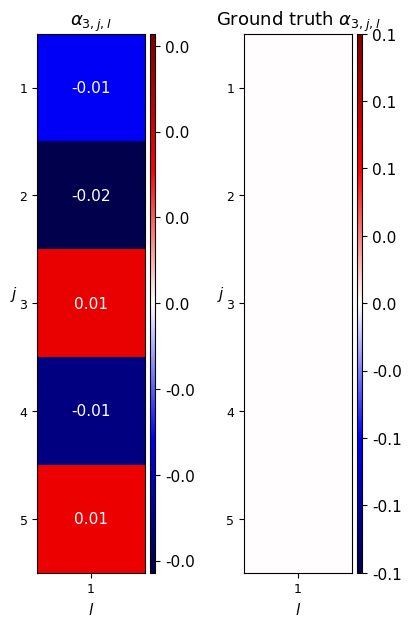

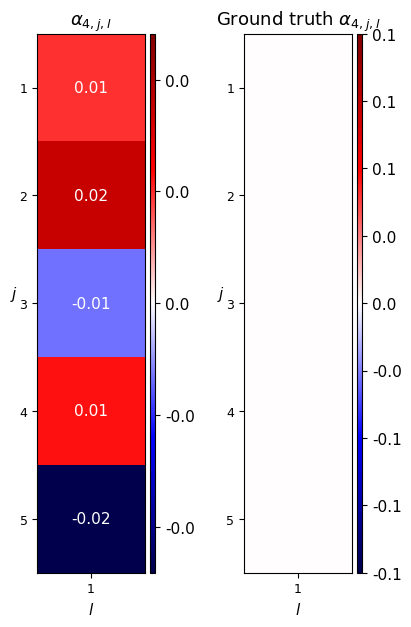

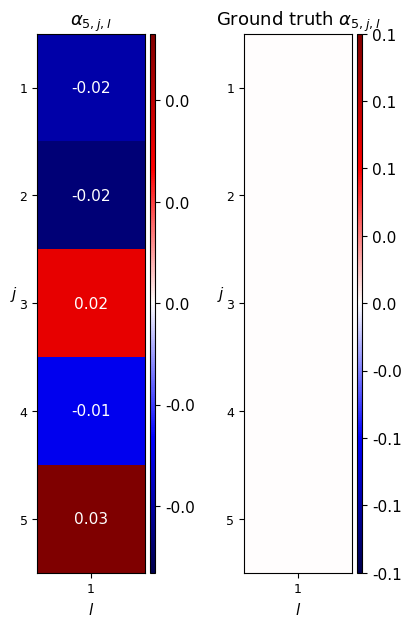

In [31]:
plot_alphas(stats['alpha'][1]['mean'],ground_truth_alpha, figsize=(8, 7), font_size=11, space=-0.8)

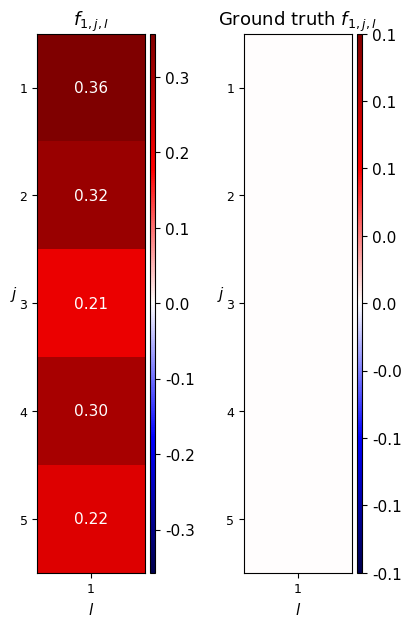

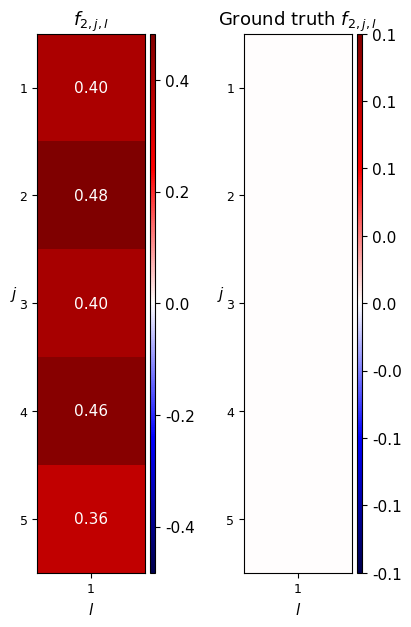

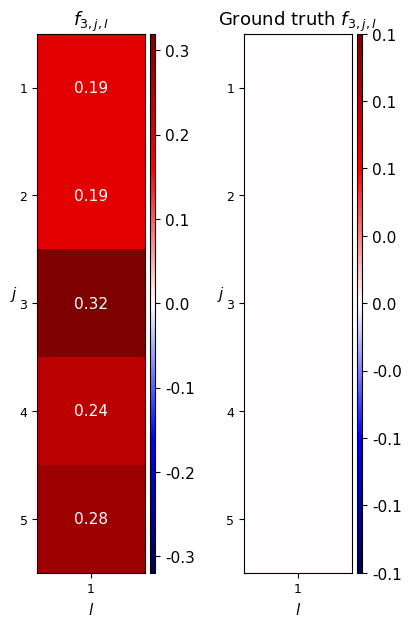

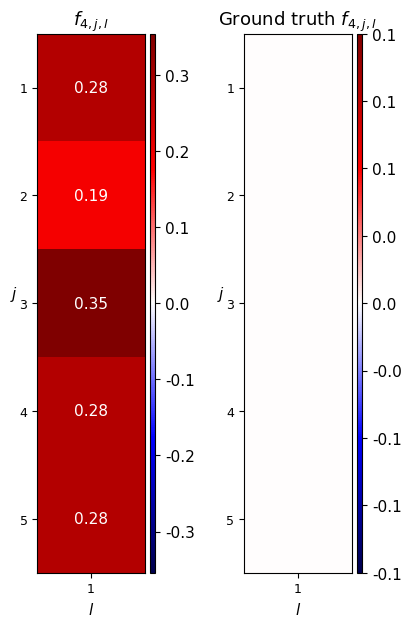

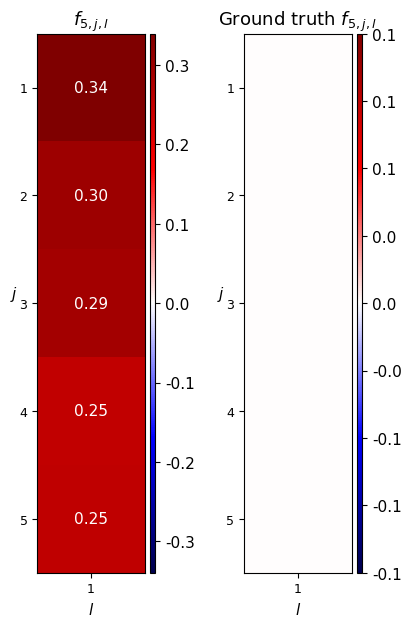

In [32]:
plot_alphas(stats['f'][1]['mean'],alpha_mask, figsize=(8, 7), title=r'f', font_size=11, space=-0.8)

# Train with order=[1,0]

In [33]:
train_config['verbose'] = True
test_loss, train_losses, val_losses, f_test, c_test, debug_info,_,_,_ = train_and_evaluate(
    time_series=time_series,
    window_size=1,
    temperature=1,
    order=[1,0],
    config=train_config
)

Epoch 1/100, Train Loss: 1.012895e-01, Val Loss: 2.698312e-02, LR: 1.00e-03
Epoch 2/100, Train Loss: 2.727511e-02, Val Loss: 2.580922e-02, LR: 1.00e-03
Epoch 3/100, Train Loss: 2.738885e-02, Val Loss: 2.708782e-02, LR: 1.00e-03
Epoch 4/100, Train Loss: 2.686172e-02, Val Loss: 2.627879e-02, LR: 1.00e-03
Epoch 5/100, Train Loss: 2.669130e-02, Val Loss: 2.648919e-02, LR: 1.00e-03
Epoch 6/100, Train Loss: 2.649670e-02, Val Loss: 2.661999e-02, LR: 1.00e-03
Epoch 7/100, Train Loss: 2.662426e-02, Val Loss: 2.558569e-02, LR: 1.00e-03
Epoch 8/100, Train Loss: 2.644576e-02, Val Loss: 2.715018e-02, LR: 1.00e-03
Epoch 9/100, Train Loss: 2.655931e-02, Val Loss: 2.684456e-02, LR: 1.00e-03
Epoch 10/100, Train Loss: 2.624469e-02, Val Loss: 2.660163e-02, LR: 1.00e-03
Epoch 11/100, Train Loss: 2.663361e-02, Val Loss: 2.605215e-02, LR: 1.00e-03
Epoch 12/100, Train Loss: 2.648907e-02, Val Loss: 2.588541e-02, LR: 1.00e-03
Epoch 13/100, Train Loss: 2.637236e-02, Val Loss: 2.689360e-02, LR: 5.00e-04
Epoch 14

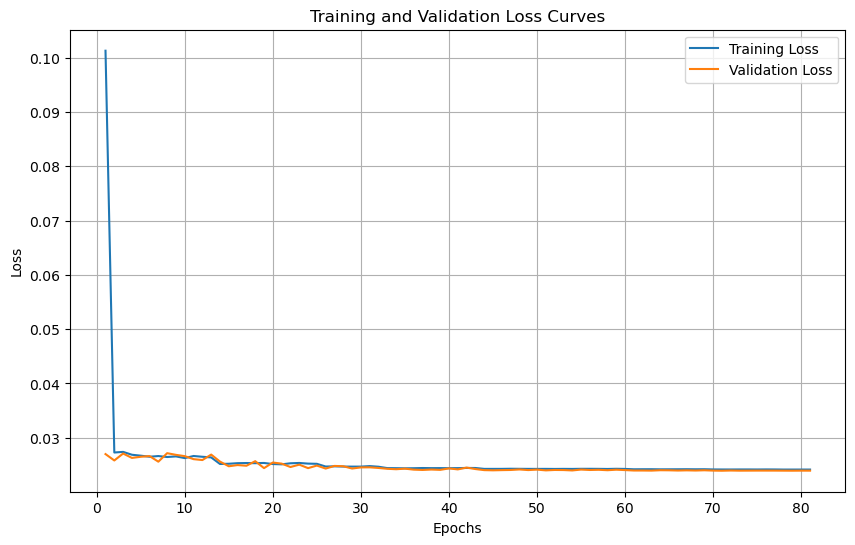

In [34]:
# Plot training and validation loss curves
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses)+1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.grid(True)

In [35]:
alpha_bias = (f_test[0] * c_test[0]).mean(0)  # Mean of bias alpha coefficients
alpha_bias_std = (f_test[0] * c_test[0]).std(0)  # Std of bias alpha coefficients

In [36]:
print_bias(alpha_bias, alpha_bias_std, ground_truth_bias)

bias_1 = (0.80426 ± 0.00002), gt_bias_1 = 0.80428
bias_2 = (1.56738 ± 0.00002), gt_bias_2 = 1.56738
bias_3 = (-0.156621 ± 0.000003), gt_bias_3 = -0.156623
bias_4 = (0.400632 ± 0.000009), gt_bias_4 = 0.400629
bias_5 = (-0.83571 ± 0.00003), gt_bias_5 = -0.83575
